In [1]:
# Modules used for handling and visualization of data
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np

# Modules used for computer vision
import cv2

# Modules used for handling files
import os
from xml.dom import minidom
import xml.etree.ElementTree as ET
import json
import shutil

# Modules used for randomization
import random as r
import pprint

# Constants
TRAIN_DIR = "../data/atrw_detection_train/trainval"
TEST_DIR = "../data/atrw_detection_test/test/"
TRAIN_ANNOT_DIR = "../data/atrw_anno_detection_train(1)/Annotations"
TAGS = ["filename", "size", "width", "height", "depth", "object", "bndbox", "xmin", "xmax", "ymin", "ymax"]

In [45]:
# Convert the annotations from XML to TXT format.
class PASCAL2YOLO:
    
   # Initialize the variables for the class
   def __init__(self, obj_map : dict):
        self.obj_map = obj_map

   # Extraction of the bounding box dimensions by parsing XML.
   def __get_bounding_box_dims(self, id: str):
        annot = {"objects": []}
        
        # Parsing the XML annotations file. 
        xml_path = os.path.join(TRAIN_ANNOT_DIR, id+".xml")
        file = ET.parse(xml_path)
        
        # Traversal through the XML Tree.
        root=file.getroot()
        
        for i in root:
            # print(i.tag)
            if i.tag in TAGS:

               if i.tag == "size":

                  img_size = []
                  for img_dim in i:
                    img_size.append(int(img_dim.text))
                  annot[i.tag] = tuple(img_size)

               elif i.tag == "object":
                  tgr = {"name": i[0].text}
                  for bnd_dim in i[-1]:
                    tgr[bnd_dim.tag] = int(bnd_dim.text)
                  annot["objects"].append(tgr)

               else:
                  annot[i.tag] = i.text
        return annot

   def convert_txt_format(self, id : str):
      annot = self.__get_bounding_box_dims(id)
      #pprint.pprint(annot)
      img_w, img_h, img_c = annot["size"]
      #print(img_h, img_w, img_c)
      new_annotations = []

      for tgr in annot["objects"]:

         obj_id = self.obj_map[tgr["name"]]

         xmin = tgr["xmin"]
         xmax = tgr["xmax"]
         ymin = tgr["ymin"]
         ymax = tgr["ymax"]
         #print(xmin, xmax, ymin, ymax)
         #print(xmin + xmax, 2*img_w)
         center_x = (xmin + xmax)/(2*img_w)
         center_y = (ymin + ymax)/(2*img_h)
         center_w = (xmax - xmin)/img_w
         center_h = (ymax - ymin)/img_h

         label = "{} {:.3f} {:.3f} {:.3f} {:.3f}".format(obj_id, center_x, center_y, 
                                                         center_w, center_h)

         new_annotations.append(label)
         
      return new_annotations
   
   def write_annotations_to_txt(self, id : str):
      #print("Entered")
      new_annotations = self.convert_txt_format(id)
      txt_path = os.path.join("../data/labels/trainval", id + ".txt")

      fp = open(txt_path, "w")
      fp.write("\n".join(new_annotations))
      fp.close()
   
   def convert_all_annotations(self):

      all_annotations = os.listdir(TRAIN_ANNOT_DIR)
      all_ids = list(map(lambda p: p.replace(".xml", ""), all_annotations))

      for id in all_ids:
         self.write_annotations_to_txt(id)
         
      print("Executed")

In [46]:
x = PASCAL2YOLO({"Tiger":0})

In [47]:
x.convert_all_annotations()

Executed


In [48]:
# Convert the annotations from JSON to TXT format.
class COCO2YOLO:

    # Initialize the variables for the class
    def __init__(self, obj_map : dict, annotations : list):
        self.obj_map = obj_map
        self.annotations = annotations
    
    def __get_dims(self, id : str):
        img_id = int(id)
        annot = {"objects": []}
        annot["filename"] = img_id

        for i in annotations["annotations"]:
            if i["image_id"] == img_id:
               tgr = {"name": "Tiger"}
               tgr["x"], tgr["y"], tgr["w"], tgr["h"] = i["bbox"]
               annot["objects"].append(tgr)
        
        return annot

    def __convert_txt_format(self, id : str):
      annot = self.__get_dims(id)
      #pprint.pprint(annot)
      img_w, img_h, img_c = (1920, 1080, 3)
      new_annotations = []

      for tgr in annot["objects"]:

         obj_id = self.obj_map[tgr["name"]]

         x = tgr["x"]
         y = tgr["y"]
         w = tgr["w"]
         h = tgr["h"]

         center_x = (x + (x + w))/(2*img_w)
         center_y = (y + (y + h))/(2*img_h)
         center_w = w/img_w
         center_h = h/img_h

         label = "{} {:.3f} {:.3f} {:.3f} {:.3f}".format(obj_id, center_x, center_y, 
                                                         center_w, center_h)

         new_annotations.append(label)
         
      return new_annotations

    def __write_annotations_to_txt(self, id : str):
      #print("Entered")
      new_annotations = self.__convert_txt_format(id)
      txt_path = os.path.join("../data/labels/test", id + ".txt")

      fp = open(txt_path, "w")
      fp.write("\n".join(new_annotations))
      fp.close()
    
    
    def convert_all_annotations(self):

      all_annotations = os.listdir(TEST_DIR)
      all_ids = list(map(lambda p: p.replace(".jpg", ""), all_annotations))

      for id in all_ids:
         self.__write_annotations_to_txt(id)
         
      print("Executed")

In [49]:
annotations = json.load(open("../data/atrw_anno_detection_test/test_labels.json", "r"))

In [50]:
x = COCO2YOLO({"Tiger":0}, annotations["annotations"])

In [51]:
x.convert_all_annotations()

Executed


In [6]:
def plot_boxes(id: str, folder: str):
    plt.figure(figsize=(10,10))
    ROOT = "../enlightened_data/dataset/"
    path_txt = os.path.join(ROOT, "labels", folder, id + ".txt")
    path_jpg = os.path.join(ROOT, "images", folder, id + ".jpg")

    annots = open(path_txt, "r").read().split("\n")
    img = cv2.imread(path_jpg)
    dw, dh, _ = (1920, 1080, 3)

    for annot in annots:
      if annot != "":
        _, x, y, w, h = map(float, annot.split(" "))
        print(x,y,w,h)
        

        l = int((x - w / 2) * dw)
        r = int((x + w / 2) * dw)
        t = int((y - h / 2) * dh)
        b = int((y + h / 2) * dh)
        
        cv2.rectangle(img, (l, t), (r, b), (0, 0, 255), 10)
    cv2.imwrite("enlightengan_sample.jpg", img)
    plt.imshow(img)
    plt.show()

0.261 0.694 0.11 0.156
0.384 0.603 0.121 0.124
0.896 0.718 0.103 0.286


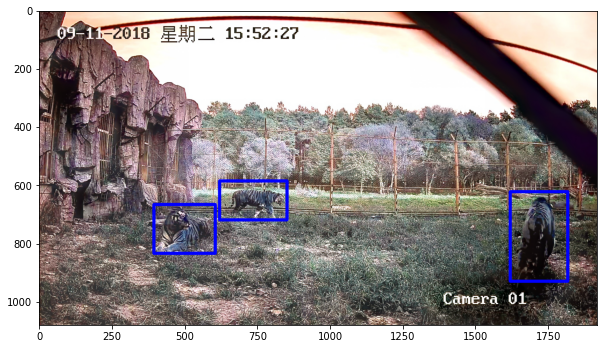

In [7]:
plot_boxes("2180", "train")

In [55]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

In [27]:
model.train(data="../final_data/data.yaml",
            epochs=1)
model.val()        

Ultralytics YOLOv8.0.6  Python-3.9.1 torch-1.12.0+cpu CPU
yolo\engine\trainer: task=detect, mode=train, model=yolov8n.yaml, data=../final_data/data.yaml, epochs=1, patience=50, batch=16, imgsz=640, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=False, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=True, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, retina_masks=False, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=17, workspace=4, nms=False, lr0=0.01, lrf=0.01, momentu

  0%|          | 0.00/755k [00:00<?, ?B/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.Conv                  [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.Conv                  [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.C2f                   [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.Conv                  [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.C2f                   [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.Conv                  [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.C2f                   [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

AttributeError: module 'torchvision' has no attribute 'ops'

In [ ]:
class EnlightenGAN:
    
    def __init__(self, img_dir: str):
        self.img_dir = img_dir
    
    def enlighten(self, path: str):
        img = cv2.imread('/kaggle/input/tiger-detection-dataset/final_data/dataset/images/test/2409.jpg')
        model = EnlightenOnnxModel()
        processed = model.predict(img)
        return processed
    
    def enhance_dataset(self):
        for img_path in os.listdir(self.img_dir):
            processed_img = enlighten(img_path)